<a href="https://colab.research.google.com/github/sof1a03/DSS_groupproject/blob/main/Code/Features/Electric_car_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sof1a03/DSS_groupproject.git

Cloning into 'DSS_groupproject'...
remote: Enumerating objects: 506, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 506 (delta 30), reused 3 (delta 3), pack-reused 451 (from 2)
Receiving objects: 100% (506/506), 26.62 MiB | 10.86 MiB/s, done.
Resolving deltas: 100% (193/193), done.


In [109]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests, time
from typing import List, Dict, Any

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, BisectingKMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    confusion_matrix, normalized_mutual_info_score
)
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from scipy.cluster.hierarchy import linkage, dendrogram

In [79]:
pd.options.display.float_format = "{:,.4f}".format
sns.set_theme(context="notebook", style="whitegrid")

# --- Paths (update if needed)
REGIONS_PATH  = "/content/DSS_groupproject/Data/Final/REGIONAL.csv"
GEMEENTE_PATH = "/content/merged_pc4_gemeente.csv"

# --- OCM API
OCM_API_KEY = "d8d6328c-6367-4a60-a97c-9db909e524c2"

# Municipality to analyze (you'll wire this to the dashboard later)
MUNICIPALITY = "Utrecht"


## 2) Load `REGIONAL.csv` and the PC4↔Gemeente mapping (`conv`)

- Load **REGIONAL** with EV/demographic features per PC4 (neighborhood rollups).
- Load **conv** with columns from your file:  
  `gemeente2023` (int), `pc4` (int), `gemeentenaam2023` (str).  
- Normalize column names, enforce integer types for safe joins, and reduce `conv` to the *minimal set of columns* with duplicates removed to keep memory in check.

In [87]:
regions = pd.read_csv(REGIONS_PATH)
# Load conv (7.9M rows). Keep only needed columns and drop duplicates to shrink memory.
conv_raw = pd.read_csv(GEMEENTE_PATH)


In [88]:
conv_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7936433 entries, 0 to 7936432
Data columns (total 3 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   Gemeente2023      int64 
 1   PC4               int64 
 2   Gemeentenaam2023  object
dtypes: int64(2), object(1)
memory usage: 181.7+ MB


In [89]:
# Normalize & rename to standard names we use downstream
conv = conv_raw.rename(columns={
    "Gemeente2023": "gm_code",
    "PC4": "pc4",
    "Gemeentenaam2023": "gm_name",
}).copy()

# Enforce types and drop bad rows early

conv["pc4"] = pd.to_numeric(conv["pc4"], errors="coerce").astype("Int64")
conv = conv.dropna(subset=["pc4", "gm_name"])
conv["pc4"] = conv["pc4"].astype(int)

In [107]:
conv = conv.dropna(subset=["pc4", "gm_name"]).copy()
conv["pc4"] = conv["pc4"].astype(int)
conv = conv[["pc4", "gm_name"]].drop_duplicates(ignore_index=True)

print("conv shape after slimming:", conv.shape)
conv.head(3)

conv shape after slimming: (4089, 2)


,pc4,gm_name
0,1011,Amsterdam
1,1012,Amsterdam
2,1013,Amsterdam


## 3) Feature preparation for clustering and analysis

- Select the core EV & socio-demographic features.  
- Clean types and compute `p_fossil` as a helper (gasoline + diesel).  
- Quick EDA: EV share vs income, colored by urbanization and sized by population.

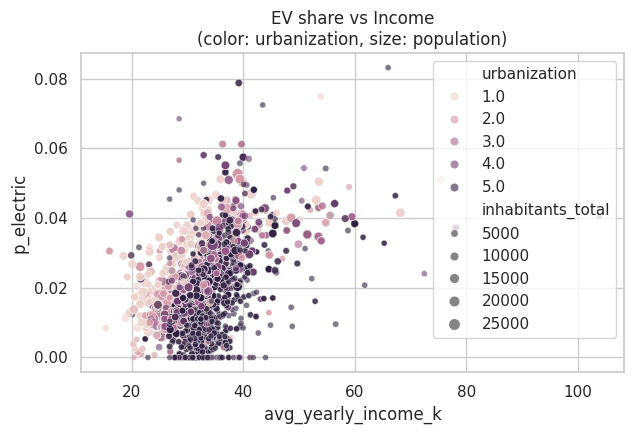

In [92]:
feat = [
    "p_electric", "p_hybrid", "p_gasoline", "p_diesel",
    "avg_yearly_income_k", "urbanization", "avg_household_size",
    "inhabitants_total", "pc4"
]

R = regions.dropna(subset=feat).copy()
for c in feat:
    R[c] = pd.to_numeric(R[c], errors="coerce")
R = R.dropna(subset=feat).copy()

# Composite fossil share (interpretation only)
R["p_fossil"] = R["p_gasoline"] + R["p_diesel"]

# Quick EDA plot
plt.figure(figsize=(6.5,4.5))
sns.scatterplot(
    data=R, x="avg_yearly_income_k", y="p_electric",
    hue="urbanization", size="inhabitants_total", alpha=0.6
)
plt.title("EV share vs Income\n(color: urbanization, size: population)")
plt.tight_layout()
plt.show()

## 4) PCA + KMeans (k via silhouette) and SOFT archetypes

- Standardize + PCA (≤5 comps).
- Evaluate k=2..6 by silhouette; fit final KMeans.
- Compute **pointwise silhouette** and **distance to centroid** for soft confidence.

k=2 silhouette=0.2585
k=3 silhouette=0.2691
k=4 silhouette=0.2477
k=5 silhouette=0.2362
k=6 silhouette=0.2225

Best k (by silhouette): 3
Final silhouette: 0.27


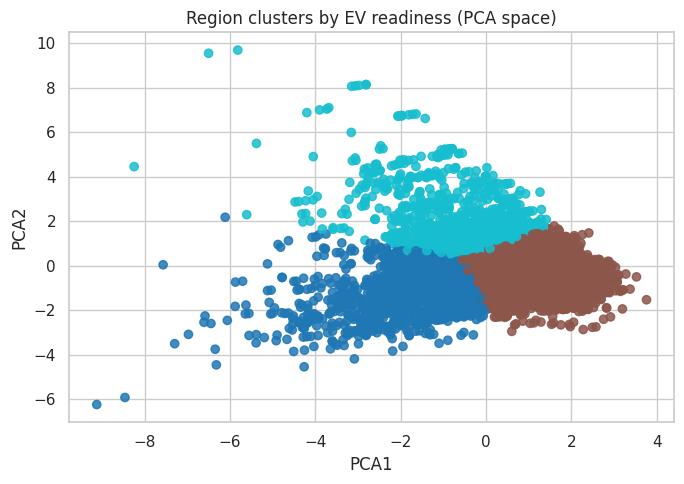

NOTE: Silhouette ≈ 0.27 → treat clusters as **soft archetypes**. Use `cluster_confidence` and `silhouette_i` downstream.


In [110]:
clust_cols = [
    "p_electric", "p_hybrid", "p_gasoline", "p_diesel",
    "avg_yearly_income_k", "urbanization", "avg_household_size"
]

X = R[clust_cols].copy()
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

pca = PCA(n_components=min(5, Xs.shape[1]))
X_p = pca.fit_transform(Xs)

k_results = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_p)
    sil = silhouette_score(X_p, labels)
    k_results.append((k, sil))
    print(f"k={k} silhouette={sil:.4f}")

best_k = max(k_results, key=lambda t: t[1])[0]
print("\nBest k (by silhouette):", best_k)

km = KMeans(n_clusters=best_k, random_state=42, n_init=20)
R["ev_cluster"] = km.fit_predict(X_p)
sil_final = silhouette_score(X_p, R["ev_cluster"])
print("Final silhouette:", round(sil_final, 4))

# Pointwise silhouette (confidence proxy)
R["silhouette_i"] = silhouette_samples(X_p, R["ev_cluster"])

# Distance to centroid (smaller is “more typical”)
centroids = km.cluster_centers_
dists = np.linalg.norm(X_p - centroids[R["ev_cluster"]], axis=1)
R["dist_to_centroid"] = dists

# Normalize distances within cluster -> confidence in [0,1] (1 = closer than typical)
R["cluster_confidence"] = 1 - (R.groupby("ev_cluster")["dist_to_centroid"]
                                 .transform(lambda s: (s - s.min()) / (s.max() - s.min() + 1e-12)))

plt.figure(figsize=(7,5))
plt.scatter(X_p[:,0], X_p[:,1], c=R["ev_cluster"], cmap="tab10", alpha=0.85)
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.title("Region clusters by EV readiness (PCA space)")
plt.tight_layout()
plt.show()

print("NOTE: Silhouette ≈", round(sil_final,3),
      "→ treat clusters as **soft archetypes**. Use `cluster_confidence` and `silhouette_i` downstream.")

## 5) Hierarchical (Agglomerative) & Divisive (Bisecting KMeans) + agreement metrics

- Ward’s hierarchical clustering on the same PCA space (`X_p`).  
- Bisecting KMeans as a divisive baseline.  
- Compare with KMeans using Silhouette, **Purity**, and **NMI**.

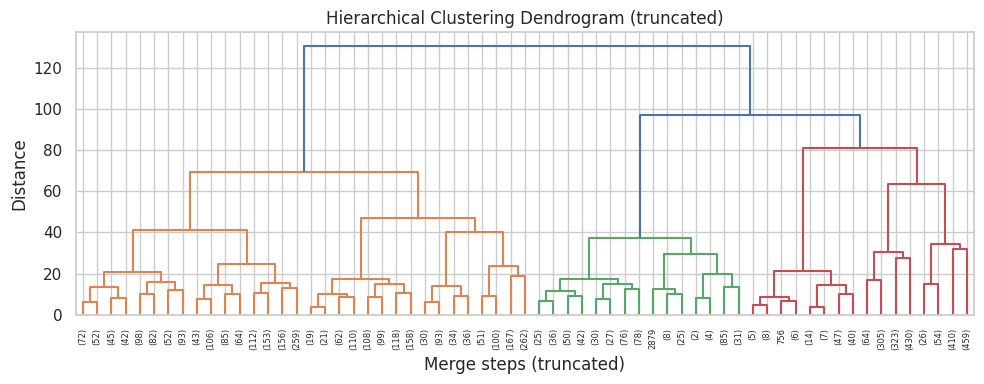


--- Cluster Comparison Summary ---
Silhouette  (KMeans)       : 0.2700
Silhouette  (Hierarchical) : 0.2319
Silhouette  (Divisive)     : 0.2553
Purity (Hier | ref=KM)     : 0.6913
Purity (Div  | ref=KM)     : 0.7892
NMI (KMeans vs Hier)       : 0.3526
NMI (KMeans vs Divisive)   : 0.5333

Recommended method (by silhouette): KMeans


In [111]:
# Hierarchical linkage (truncated dendrogram)
Z = linkage(X_p, method="ward")
plt.figure(figsize=(10, 4))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Merge steps (truncated)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Labels at same k as KMeans for comparability
n_hier = best_k
hc = AgglomerativeClustering(n_clusters=n_hier, linkage="ward")
R["ev_cluster_hier"] = hc.fit_predict(X_p)
sil_hier = silhouette_score(X_p, R["ev_cluster_hier"])

# Divisive clustering
div_kmeans = BisectingKMeans(n_clusters=best_k, random_state=42)
R["ev_cluster_div"] = div_kmeans.fit_predict(X_p)
sil_div = silhouette_score(X_p, R["ev_cluster_div"])

def purity_score(y_ref, y_pred):
    cm = confusion_matrix(y_ref, y_pred)
    return np.sum(np.max(cm, axis=0)) / np.sum(cm)

y_km, y_hier, y_div = R["ev_cluster"].to_numpy(), R["ev_cluster_hier"].to_numpy(), R["ev_cluster_div"].to_numpy()
purity_hier = purity_score(y_km, y_hier)
purity_div  = purity_score(y_km, y_div)
nmi_hier    = normalized_mutual_info_score(y_km, y_hier)
nmi_div     = normalized_mutual_info_score(y_km, y_div)

print("\n--- Cluster Comparison Summary ---")
print(f"Silhouette  (KMeans)       : {sil_final:.4f}")
print(f"Silhouette  (Hierarchical) : {sil_hier:.4f}")
print(f"Silhouette  (Divisive)     : {sil_div:.4f}")
print(f"Purity (Hier | ref=KM)     : {purity_hier:.4f}")
print(f"Purity (Div  | ref=KM)     : {purity_div:.4f}")
print(f"NMI (KMeans vs Hier)       : {nmi_hier:.4f}")
print(f"NMI (KMeans vs Divisive)   : {nmi_div:.4f}")

if sil_hier > max(sil_final, sil_div):
    best_method = "Hierarchical (Ward)"
elif sil_div > max(sil_final, sil_hier):
    best_method = "Divisive (Bisecting K-Means)"
elif sil_final > max(sil_hier, sil_div):
    best_method = "KMeans"
else:
    best_method = "Equal / tie"
print(f"\nRecommended method (by silhouette): {best_method}")

## 6) Cluster labeling and profiles

Assign stable labels (Cluster_1, Cluster_2, …) by sorting clusters on median `p_electric`.  
Show median profiles to interpret archetypes (income/urbanization/EV mix).

In [112]:
profile_cols = [
    "p_electric", "p_hybrid", "p_gasoline", "p_diesel",
    "avg_yearly_income_k", "urbanization",
    "avg_household_size", "inhabitants_total"
]
profile = (
    R.groupby("ev_cluster")[profile_cols]
     .median()
     .reset_index()
     .sort_values("p_electric", ascending=False)
)
order = profile["ev_cluster"].tolist()
label_map = {c: f"Cluster_{i+1}" for i, c in enumerate(order)}
R["cluster_label"] = R["ev_cluster"].map(label_map)

display(profile)

,ev_cluster,p_electric,p_hybrid,p_gasoline,p_diesel,avg_yearly_income_k,urbanization,avg_household_size,inhabitants_total
2,2,0.0347,0.0210,0.8223,0.1036,38.0000,3.0000,2.3000,"8,955.0000"
1,1,0.0204,0.0119,0.8559,0.0991,30.4000,2.0000,2.1000,"9,190.0000"
0,0,0.0171,0.0133,0.8000,0.1523,33.0000,5.0000,2.5000,"3,390.0000"


## 7) EV Potential Index (0–100) with **fixed-quantile scaling** (stable)

Heuristic:
  + income, + urbanization, + hybrid
  – diesel, – gasoline
Scale using fixed national quantiles (e.g., 1%–99%) instead of min–max to avoid instability across municipalities/time.


In [113]:
def quantile_scale(series, q_low=0.01, q_high=0.99):
    s = pd.to_numeric(series, errors="coerce").astype(float)
    lo, hi = s.quantile(q_low), s.quantile(q_high)
    s_clipped = s.clip(lo, hi)
    return 100 * (s_clipped - lo) / (hi - lo + 1e-12)

potential_cols = ["avg_yearly_income_k", "urbanization", "p_hybrid", "p_diesel", "p_gasoline"]
Z_ = R[potential_cols].copy()
Z_ = (Z_ - Z_.mean()) / (Z_.std(ddof=0).replace(0, 1e-9))

R["EV_Potential_raw"] = (
    Z_["avg_yearly_income_k"] + Z_["urbanization"] + Z_["p_hybrid"]
    - Z_["p_diesel"] - Z_["p_gasoline"]
) / 5.0

# Fixed quantile scaling to 0–100 (stable)
R["EV_Potential_0_100"] = quantile_scale(R["EV_Potential_raw"], 0.01, 0.99)

ev_pot = R[["pc4", "EV_Potential_0_100", "EV_Potential_raw", "cluster_label",
            "p_electric", "p_hybrid", "p_diesel", "p_gasoline",
            "avg_yearly_income_k", "urbanization", "inhabitants_total",
            "cluster_confidence", "silhouette_i"]].copy()

display(ev_pot.sort_values("EV_Potential_0_100", ascending=False).head(10))

,pc4,EV_Potential_0_100,EV_Potential_raw,cluster_label,p_electric,p_hybrid,p_diesel,p_gasoline,avg_yearly_income_k,urbanization,inhabitants_total,cluster_confidence,silhouette_i
1613,2051,100.0000,1.6210,Cluster_1,0.0430,0.0376,0.1011,0.8105,53.5000,4.0000,"4,485.0000",0.7508,0.3560
553,1217,100.0000,1.6537,Cluster_1,0.0408,0.0365,0.1013,0.8110,55.6000,4.0000,"8,295.0000",0.7473,0.3436
2103,2952,100.0000,1.6104,Cluster_1,0.0421,0.0421,0.1017,0.8014,44.0000,5.0000,"1,290.0000",0.6915,0.2262
1615,2051,100.0000,1.7513,Cluster_1,0.0430,0.0376,0.1011,0.8105,53.5000,5.0000,"4,485.0000",0.7339,0.3266
3562,6891,100.0000,1.6469,Cluster_1,0.0543,0.0397,0.1310,0.7660,50.9000,4.0000,"1,745.0000",0.7074,0.3122
499,1184,100.0000,2.5009,Cluster_1,0.0241,0.0481,0.0928,0.8316,72.5000,4.0000,610.0000,0.4799,0.2069
1659,2111,100.0000,2.7299,Cluster_1,0.0372,0.0474,0.1014,0.8071,78.2000,4.0000,"4,865.0000",0.4390,0.2166
1657,2111,100.0000,2.5996,Cluster_1,0.0372,0.0474,0.1014,0.8071,78.2000,3.0000,"4,865.0000",0.4440,0.2216
1656,2111,100.0000,2.8601,Cluster_1,0.0372,0.0474,0.1014,0.8071,78.2000,5.0000,"4,865.0000",0.4231,0.1989
571,1251,100.0000,1.6304,Cluster_1,0.0353,0.0369,0.1032,0.8164,51.5000,5.0000,"11,350.0000",0.7578,0.2897


## 8) Opportunity sizing

Favor regions that are both ready *and* sizable:  
`Opportunity = EV_Potential_0_100 × log(1 + inhabitants_total)`.

In [114]:
R["Opportunity"] = R["EV_Potential_0_100"] * np.log1p(R["inhabitants_total"])
opp = R[["pc4", "cluster_label", "EV_Potential_0_100", "inhabitants_total", "Opportunity",
         "p_electric", "p_hybrid", "p_diesel", "p_gasoline",
         "avg_yearly_income_k", "urbanization"]].copy()
display(opp.sort_values("Opportunity", ascending=False).head(10))

,pc4,cluster_label,EV_Potential_0_100,inhabitants_total,Opportunity,p_electric,p_hybrid,p_diesel,p_gasoline,avg_yearly_income_k,urbanization
260,1071,Cluster_1,100.0000,"12,640.0000",944.4701,0.0415,0.0455,0.0998,0.8036,68.2000,1.0000
259,1071,Cluster_1,100.0000,"12,640.0000",944.4701,0.0415,0.0455,0.0998,0.8036,68.2000,1.0000
261,1071,Cluster_1,100.0000,"12,640.0000",944.4701,0.0415,0.0455,0.0998,0.8036,68.2000,1.0000
262,1071,Cluster_1,100.0000,"12,640.0000",944.4701,0.0415,0.0455,0.0998,0.8036,68.2000,1.0000
263,1071,Cluster_1,100.0000,"12,640.0000",944.4701,0.0415,0.0455,0.0998,0.8036,68.2000,1.0000
265,1071,Cluster_1,100.0000,"12,640.0000",944.4701,0.0415,0.0455,0.0998,0.8036,68.2000,1.0000
266,1071,Cluster_1,100.0000,"12,640.0000",944.4701,0.0415,0.0455,0.0998,0.8036,68.2000,1.0000
264,1071,Cluster_1,100.0000,"12,640.0000",944.4701,0.0415,0.0455,0.0998,0.8036,68.2000,1.0000
571,1251,Cluster_1,100.0000,"11,350.0000",933.7061,0.0353,0.0369,0.1032,0.8164,51.5000,5.0000
568,1251,Cluster_1,100.0000,"11,350.0000",933.7061,0.0353,0.0369,0.1032,0.8164,51.5000,5.0000


9) Ridge 'what-if' structural model + validation (SMAPE, MAE, CV)

- Hold-out (20%) → R², SMAPE, MAE; residual plots.
- KFold(5) CV → MAE and SMAPE (via custom scorer).

Ridge α: 251.18864315095772
Hold-out R²: 0.49609653570850953
Hold-out SMAPE (%): 13.229
Hold-out MAE: 0.0049
CV(5) MAE   : 0.0052 ± 0.0002
CV(5) SMAPE%: 13.523 ± 0.259


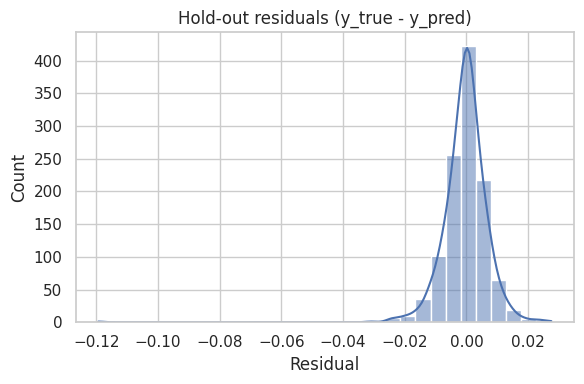

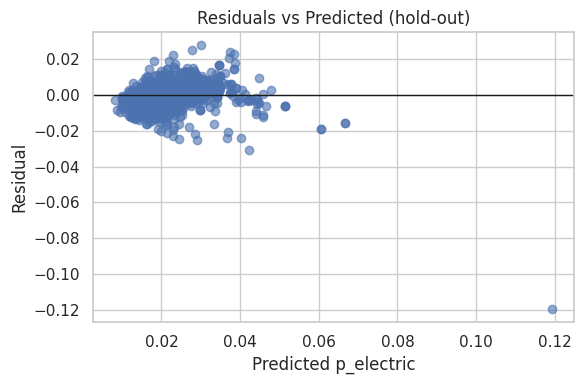

In [115]:
def smape_numpy(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))
    return 100 * np.mean(np.where(denom == 0, 0.0, np.abs(y_true - y_pred) / denom))

def mae_numpy(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.mean(np.abs(y_true - y_pred))

from sklearn.metrics import make_scorer
smape_scorer = make_scorer(lambda yt, yp: -smape_numpy(yt, yp))  # negative to use cross_val_score's "higher is better"
mae_scorer   = make_scorer(lambda yt, yp: -mae_numpy(yt, yp))

X_cols = ["avg_yearly_income_k", "urbanization", "p_hybrid", "p_gasoline", "p_diesel"]
y_col = "p_electric"

R_fit = R.dropna(subset=X_cols + [y_col]).copy()
X_all, y_all = R_fit[X_cols], R_fit[y_col]

# Hold-out
X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
pipe = Pipeline([("scaler", StandardScaler()),
                 ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 21), cv=5))])
pipe.fit(X_tr, y_tr)
y_hat_te = pipe.predict(X_te)
print("Ridge α:", pipe.named_steps["ridge"].alpha_)
print("Hold-out R²:", pipe.score(X_te, y_te))
print("Hold-out SMAPE (%):", round(smape_numpy(y_te, y_hat_te), 3))
print("Hold-out MAE:", round(mae_numpy(y_te, y_hat_te), 4))

# CV (K=5) — MAE and SMAPE
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae   = -cross_val_score(pipe, X_all, y_all, scoring=mae_scorer, cv=kf)
cv_smape = -cross_val_score(pipe, X_all, y_all, scoring=smape_scorer, cv=kf)
print("CV(5) MAE   :", round(cv_mae.mean(), 4), "±", round(cv_mae.std(), 4))
print("CV(5) SMAPE%:", round(cv_smape.mean(), 3), "±", round(cv_smape.std(), 3))

# Residual diagnostics
residuals = y_te - y_hat_te
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Hold-out residuals (y_true - y_pred)")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_hat_te, residuals, alpha=0.6)
plt.axhline(0, color="k", lw=1)
plt.title("Residuals vs Predicted (hold-out)")
plt.xlabel("Predicted p_electric"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

# Fit full model for scenario predictions
model = Pipeline([("scaler", StandardScaler()),
                  ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 21), cv=5))]).fit(X_all, y_all)

R["p_electric_hat"] = model.predict(R[X_cols])

def scenario_df(df, income_mul=1.0, income_add=0.0,
                urb_add=0.0, hybrid_mul=1.0, fossil_rel_drop=0.0):
    S = df.copy()
    S["avg_yearly_income_k"] = S["avg_yearly_income_k"] * income_mul + income_add
    # In REGIONAL, 'urbanization' ~ 1..5; clamp changes to [1,5]
    S["urbanization"] = np.clip(S["urbanization"] + urb_add, 1, 5)
    S["p_hybrid"]     = np.clip(S["p_hybrid"] * hybrid_mul, 0, 1)
    S["p_gasoline"]   = np.clip(S["p_gasoline"] * (1 - fossil_rel_drop), 0, 1)
    S["p_diesel"]     = np.clip(S["p_diesel"]   * (1 - fossil_rel_drop), 0, 1)
    return S

# National scenario (used for some plots)
S = scenario_df(R, income_mul=1.10, urb_add=0.05, hybrid_mul=2.0, fossil_rel_drop=0.10)
S["p_electric_hat_scn"]   = model.predict(S[X_cols])
S["delta_p_electric_hat"] = S["p_electric_hat_scn"] - R["p_electric_hat"]


## 10) OpenChargeMap: fetch → flatten → aggregate (PC4) + QA

- Extract PC4 from postcode, compute fast (≥50kW) & ultra-fast (≥150kW) port counts.
- Aggregate to PC4: stations, ports, power, operational_share.
- QA: % POIs with PC4; national fast/ultra-fast shares.

In [99]:
# Session with API key
_session = requests.Session()
assert OCM_API_KEY, "Set OCM_API_KEY in environment."
_session.headers.update({
    "User-Agent": "EV-Insights/1.0 (Academic Dashboard)",
    "X-API-Key": OCM_API_KEY
})

def fetch_ocm_nl(maxresults: int = 50000) -> List[Dict[str, Any]]:
    url = "https://api.openchargemap.io/v3/poi/"
    params = {
        "output": "json",
        "countrycode": "NL",
        "maxresults": maxresults,
        "compact": "true",
        "verbose": "false"
    }
    r = _session.get(url, params=params, timeout=180)
    r.raise_for_status()
    return r.json()

def _safe(d: Dict, *keys, default=None):
    cur = d
    for k in keys:
        if cur is None:
            return default
        cur = cur.get(k)
    return cur if cur is not None else default

def flatten_ocm(records: List[Dict[str, Any]]) -> pd.DataFrame:
    rows = []
    for r in records:
        addr = _safe(r, "AddressInfo", default={}) or {}
        pc_raw = addr.get("Postcode", None)
        digits = "".join(ch for ch in str(pc_raw) if ch and str(ch).isdigit())
        pc4 = int(digits[:4]) if digits and len(digits) >= 4 else None

        conns = r.get("Connections", []) or []
        n_ports = 0
        total_kw = 0.0
        fast_ports = 0
        ultra_ports = 0
        kw_list = []

        for c in conns:
            n_ports += 1
            kw = c.get("PowerKW", None)
            if kw is None:
                continue
            try:
                kw = float(kw)
                kw_list.append(kw)
                total_kw += kw
                if kw >= 150:
                    ultra_ports += 1
                elif kw >= 50:
                    fast_ports += 1
            except Exception:
                pass

        rows.append({
            "poi_id": r.get("ID"),
            "town": addr.get("Town"),
            "postcode_raw": pc_raw,
            "pc4": pc4,
            "latitude": addr.get("Latitude"),
            "longitude": addr.get("Longitude"),
            "is_operational": bool(_safe(r, "StatusType", "IsOperational", default=np.nan))
                               if _safe(r, "StatusType", "IsOperational", default=None) is not None else np.nan,
            "status_title": _safe(r, "StatusType", "Title"),
            "operator": _safe(r, "OperatorInfo", "Title"),
            "n_ports": n_ports,
            "fast_ports": fast_ports,
            "ultra_fast_ports": ultra_ports,
            "total_power_kw": total_kw,
            "avg_power_kw": (np.mean(kw_list) if kw_list else np.nan),
            "date_created": r.get("DateCreated"),
            "date_last_update": r.get("DateLastStatusUpdate"),
        })

    df = pd.DataFrame(rows)
    if not df.empty:
        df["pc4"] = pd.to_numeric(df["pc4"], errors="coerce").astype("Int64")
    return df

def ocm_pc4_aggregate(df_flat: pd.DataFrame) -> pd.DataFrame:
    if df_flat is None or df_flat.empty:
        return pd.DataFrame(columns=[
            "pc4","n_stations","n_operational","operational_share",
            "n_ports","fast_ports","ultra_fast_ports",
            "total_power_kw","avg_power_kw"
        ])
    g = (
        df_flat.dropna(subset=["pc4"])
               .groupby("pc4", as_index=False)
               .agg(
                   n_stations=("poi_id", "nunique"),
                   n_operational=("is_operational", lambda s: np.nansum(np.array(s, dtype=float))),
                   n_ports=("n_ports", "sum"),
                   fast_ports=("fast_ports", "sum"),
                   ultra_fast_ports=("ultra_fast_ports", "sum"),
                   total_power_kw=("total_power_kw", "sum"),
                   avg_power_kw=("avg_power_kw", "mean"),
               )
    )
    g["operational_share"] = np.where(g["n_stations"] > 0, g["n_operational"] / g["n_stations"], np.nan)
    g["pc4"] = g["pc4"].astype(int)
    return g[[
        "pc4","n_stations","n_operational","operational_share",
        "n_ports","fast_ports","ultra_fast_ports",
        "total_power_kw","avg_power_kw"
    ]]

print("[info] Fetching OCM POIs for NL…")
ocm_raw = fetch_ocm_nl(maxresults=50000)
print(f"[ok] Retrieved {len(ocm_raw):,} OCM records.")

ocm_flat = flatten_ocm(ocm_raw)
print(f"[ok] Flattened to {len(ocm_flat):,} POI rows.")

ocm_pc4 = ocm_pc4_aggregate(ocm_flat)
print(f"[ok] Aggregated to {len(ocm_pc4):,} PC4 rows.")

pct_with_pc4 = 100.0 * (ocm_flat["pc4"].notna().mean() if not ocm_flat.empty else 0)
print(f"Share of POIs with a postcode-derived PC4: {pct_with_pc4:.1f}%")

[info] Fetching OCM POIs for NL…
[ok] Retrieved 8,119 OCM records.
[ok] Flattened to 8,119 POI rows.
[ok] Aggregated to 2,356 PC4 rows.
Share of POIs with a postcode-derived PC4: 98.9%


In [116]:
if not ocm_flat.empty:
    total_ports = ocm_flat["n_ports"].fillna(0).sum()
    fast_ports  = ocm_flat["fast_ports"].fillna(0).sum()
    ultra_ports = ocm_flat["ultra_fast_ports"].fillna(0).sum()
    fast_share_nat  = (fast_ports / total_ports) if total_ports > 0 else np.nan
    ultra_share_nat = (ultra_ports / total_ports) if total_ports > 0 else np.nan
    print(f"[QA/National] Ports total={total_ports:,.0f} | fast_share={fast_share_nat:.3f} | ultra_share={ultra_share_nat:.3f}")

[QA/National] Ports total=13,074 | fast_share=0.035 | ultra_share=0.012


## 11) Municipality → PC4 selection + join REGIONAL & OCM + density KPIs

- Keep PC4 join (consistent with REGIONAL).
- OPTIONAL stub for lat/long+radius fetch is included below (commented).

In [117]:
def pc4s_for_municipality(gm_query: str, conv_df: pd.DataFrame) -> pd.DataFrame:
    q = gm_query.strip().lower()
    m = conv_df[conv_df["gm_name"].str.lower().str.contains(q, na=False)].copy()
    return m[["pc4","gm_name"]].drop_duplicates()

# Ensure integer pc4 in REGIONAL for join
R_valid = R.dropna(subset=["pc4"]).copy()
R_valid["pc4"] = R_valid["pc4"].astype(int)

pc4_map = pc4s_for_municipality(MUNICIPALITY, conv)
if pc4_map.empty:
    raise ValueError(f"No PC4 found for municipality: '{MUNICIPALITY}'")

mun_pc4s = set(pc4_map["pc4"].tolist())
R_mun = R_valid[R_valid["pc4"].isin(mun_pc4s)].copy()

mun = R_mun.merge(ocm_pc4, on="pc4", how="left")

mun["chargers_per_10k"] = np.where(
    mun["inhabitants_total"] > 0,
    (mun["n_ports"].fillna(0) / mun["inhabitants_total"]) * 10000.0,
    np.nan
)
mun["stations_per_10k"] = np.where(
    mun["inhabitants_total"] > 0,
    (mun["n_stations"].fillna(0) / mun["inhabitants_total"]) * 10000.0,
    np.nan
)

print(f"[ok] Municipality join size: {len(mun):,} PC4 for '{MUNICIPALITY}'")
display(mun.head())

# QA – municipality operational/fast/ultra shares
m_total_stations = mun["n_stations"].fillna(0).sum()
m_operational    = mun["n_operational"].fillna(0).sum()
m_oper_share     = (m_operational / m_total_stations) if m_total_stations > 0 else np.nan

m_total_ports = mun["n_ports"].fillna(0).sum()
m_fast_ports  = mun["fast_ports"].fillna(0).sum()
m_ultra_ports = mun["ultra_fast_ports"].fillna(0).sum()
m_fast_share  = (m_fast_ports / m_total_ports) if m_total_ports > 0 else np.nan
m_ultra_share = (m_ultra_ports / m_total_ports) if m_total_ports > 0 else np.nan

print(f"[QA/{MUNICIPALITY}] stations={m_total_stations:,.0f}, operational={m_operational:,.0f}, operational_share={m_oper_share:.3f}")
print(f"[QA/{MUNICIPALITY}] ports={m_total_ports:,.0f}, fast_share={m_fast_share:.3f}, ultra_share={m_ultra_share:.3f}")

# OPTIONAL: lat/long + radius OCM fetch (if you have a centroid) — kept as stub:
# def fetch_ocm_radius(lat, lon, distance_km=10, maxresults=5000):
#     url = "https://api.openchargemap.io/v3/poi/"
#     params = {"output":"json","latitude":lat,"longitude":lon,"distance":distance_km,"distanceunit":"KM",
#               "maxresults":maxresults,"compact":"true","verbose":"false"}
#     r = _session.get(url, params=params, timeout=120); r.raise_for_status(); return r.json()


[ok] Municipality join size: 105 PC4 for 'Utrecht'


,nbh_code,avg_household_size,avg_house_value_woz,urbanization,std_avg_household_size,std_avg_house_value_woz,std_urbanization,pc4,p_gasoline,p_diesel,...,n_stations,n_operational,operational_share,n_ports,fast_ports,ultra_fast_ports,total_power_kw,avg_power_kw,chargers_per_10k,stations_per_10k
0,03441013,2.5000,564.0000,3.0000,0.5376,0.7897,-0.3674,3451,0.8272,0.1059,...,9.0000,0.0000,0.0000,10.0000,0.0000,0.0000,106.3000,10.5889,7.6307,6.8676
1,03441022,2.7000,542.0000,2.0000,0.9888,0.6599,-1.0423,3451,0.8272,0.1059,...,9.0000,0.0000,0.0000,10.0000,0.0000,0.0000,106.3000,10.5889,7.6307,6.8676
2,03441014,3.2000,"1,015.0000",2.0000,2.1168,3.4510,-1.0423,3451,0.8272,0.1059,...,9.0000,0.0000,0.0000,10.0000,0.0000,0.0000,106.3000,10.5889,7.6307,6.8676
3,03441021,2.9000,597.0000,2.0000,1.4400,0.9845,-1.0423,3451,0.8272,0.1059,...,9.0000,0.0000,0.0000,10.0000,0.0000,0.0000,106.3000,10.5889,7.6307,6.8676
4,03441012,2.5000,869.0000,5.0000,0.5376,2.5895,0.9824,3451,0.8272,0.1059,...,9.0000,0.0000,0.0000,10.0000,0.0000,0.0000,106.3000,10.5889,7.6307,6.8676


[QA/Utrecht] stations=583, operational=0, operational_share=0.000
[QA/Utrecht] ports=1,044, fast_share=0.008, ultra_share=0.004


## 12) Top-10 by EV usage + composite rank (transparent weights)

- Plain Top-10 by `p_electric`.
- Composite: score = (w1\*p_electric_norm + w2\*chargers_per_10k_norm) × log(1+population).

In [118]:
# Plain usage Top-10
top10_usage = (
    mun[[
        "pc4","cluster_label","p_electric","avg_yearly_income_k","urbanization",
        "n_stations","n_ports","fast_ports","ultra_fast_ports",
        "chargers_per_10k","stations_per_10k","inhabitants_total",
        "cluster_confidence","silhouette_i"
    ]]
    .sort_values("p_electric", ascending=False)
    .head(10)
    .reset_index(drop=True)
)
display(top10_usage)

# Composite ranking (weights are transparent and adjustable)
def minmax(s):
    s = pd.to_numeric(s, errors="coerce").astype(float)
    mn, mx = np.nanmin(s), np.nanmax(s)
    if not np.isfinite(mn) or not np.isfinite(mx) or mx - mn < 1e-12:
        return pd.Series(np.zeros(len(s), dtype=float), index=s.index)
    return (s - mn) / (mx - mn)

w1, w2 = 0.6, 0.4
m = mun.copy()
m["p_electric_norm"]     = minmax(m["p_electric"].fillna(0))
m["chargers_per_10k_n"]  = minmax(m["chargers_per_10k"].fillna(0))
m["score_basic"]         = w1*m["p_electric_norm"] + w2*m["chargers_per_10k_n"]
m["score_composite"]     = m["score_basic"] * np.log1p(m["inhabitants_total"].fillna(0))

top10_composite = (
    m[["pc4","cluster_label","p_electric","chargers_per_10k",
       "inhabitants_total","score_composite","cluster_confidence","silhouette_i"]]
    .sort_values("score_composite", ascending=False)
    .head(10)
    .reset_index(drop=True)
)
display(top10_composite)
print(f"Composite formula: score = ({w1} * p_electric_norm + {w2} * chargers_per_10k_norm) × log(1+population)")


,pc4,cluster_label,p_electric,avg_yearly_income_k,urbanization,n_stations,n_ports,fast_ports,ultra_fast_ports,chargers_per_10k,stations_per_10k,inhabitants_total,cluster_confidence,silhouette_i
0,3545,Cluster_1,0.0575,35.5000,4.0000,NaN,NaN,NaN,NaN,0.0000,0.0000,"1,840.0000",0.7098,0.1363
1,3545,Cluster_1,0.0575,35.5000,5.0000,NaN,NaN,NaN,NaN,0.0000,0.0000,"1,840.0000",0.7217,0.1389
2,3541,Cluster_1,0.0511,35.9000,1.0000,1.0000,1.0000,0.0000,0.0000,0.9766,0.9766,"10,240.0000",0.7444,0.2035
3,3541,Cluster_1,0.0511,35.9000,1.0000,1.0000,1.0000,0.0000,0.0000,0.9766,0.9766,"10,240.0000",0.7782,0.2432
4,3541,Cluster_1,0.0511,35.9000,1.0000,1.0000,1.0000,0.0000,0.0000,0.9766,0.9766,"10,240.0000",0.7605,0.1930
5,3543,Cluster_1,0.0510,37.4000,4.0000,5.0000,7.0000,0.0000,0.0000,5.9983,4.2845,"11,670.0000",0.8532,0.2902
6,3543,Cluster_1,0.0510,37.4000,2.0000,5.0000,7.0000,0.0000,0.0000,5.9983,4.2845,"11,670.0000",0.8632,0.3365
7,3543,Cluster_1,0.0510,37.4000,2.0000,5.0000,7.0000,0.0000,0.0000,5.9983,4.2845,"11,670.0000",0.8382,0.3272
8,3452,Cluster_1,0.0502,39.9000,2.0000,4.0000,5.0000,0.0000,0.0000,3.2949,2.6359,"15,175.0000",0.8047,0.2783
9,3581,Cluster_1,0.0466,35.1000,1.0000,30.0000,32.0000,0.0000,0.0000,32.3396,30.3183,"9,895.0000",0.8296,0.2077


,pc4,cluster_label,p_electric,chargers_per_10k,inhabitants_total,score_composite,cluster_confidence,silhouette_i
0,3452,Cluster_1,0.0502,3.2949,"15,175.0000",5.0499,0.8047,0.2783
1,3543,Cluster_1,0.0510,5.9983,"11,670.0000",4.9959,0.8532,0.2902
2,3543,Cluster_1,0.0510,5.9983,"11,670.0000",4.9959,0.8382,0.3272
3,3543,Cluster_1,0.0510,5.9983,"11,670.0000",4.9959,0.8632,0.3365
4,3541,Cluster_1,0.0511,0.9766,"10,240.0000",4.9294,0.7444,0.2035
5,3541,Cluster_1,0.0511,0.9766,"10,240.0000",4.9294,0.7782,0.2432
6,3541,Cluster_1,0.0511,0.9766,"10,240.0000",4.9294,0.7605,0.1930
7,3581,Cluster_1,0.0466,32.3396,"9,895.0000",4.5747,0.8296,0.2077
8,3581,Cluster_1,0.0466,32.3396,"9,895.0000",4.5747,0.8555,0.2395
9,3545,Cluster_1,0.0575,0.0000,"1,840.0000",4.5108,0.7217,0.1389


Composite formula: score = (0.6 * p_electric_norm + 0.4 * chargers_per_10k_norm) × log(1+population)


## 13) Municipality-level what-if “transition” forecast (structural)

- Reuse the fitted Ridge model to estimate baseline and scenario `p_electric` **for municipality PC4s**.  
- Compute uplift `Δ = scenario − baseline` and show the top gainers.

In [102]:
X_cols = ["avg_yearly_income_k", "urbanization", "p_hybrid", "p_gasoline", "p_diesel"]
y_col  = "p_electric"

mun_pred = mun.dropna(subset=X_cols).copy()
mun_pred["p_electric_hat"] = model.predict(mun_pred[X_cols])

SCENARIO = dict(income_mul=1.10, urb_add=0.05, hybrid_mul=2.0, fossil_rel_drop=0.10)
S_mun = scenario_df(mun_pred, **SCENARIO)
S_mun["p_electric_hat_scn"]   = model.predict(S_mun[X_cols])
S_mun["delta_p_electric_hat"] = S_mun["p_electric_hat_scn"] - mun_pred["p_electric_hat"]

forecast_view = (
    S_mun[[
        "pc4","cluster_label","p_electric","p_electric_hat","p_electric_hat_scn",
        "delta_p_electric_hat",
        "avg_yearly_income_k","urbanization","p_hybrid","p_gasoline","p_diesel",
        "n_stations","n_ports","fast_ports","ultra_fast_ports","chargers_per_10k"
    ]]
    .sort_values("delta_p_electric_hat", ascending=False)
    .reset_index(drop=True)
)
display(forecast_view.head(10))

,pc4,cluster_label,p_electric,p_electric_hat,p_electric_hat_scn,delta_p_electric_hat,avg_yearly_income_k,urbanization,p_hybrid,p_gasoline,p_diesel,n_stations,n_ports,fast_ports,ultra_fast_ports,chargers_per_10k
0,3584,Cluster_1,0.0412,0.0277,0.0507,0.0231,21.5600,3.0500,0.0687,0.7200,0.1035,10.0000,44.0000,0.0000,0.0000,62.1908
1,3584,Cluster_1,0.0412,0.0260,0.0490,0.0231,21.5600,4.0500,0.0687,0.7200,0.1035,10.0000,44.0000,0.0000,0.0000,62.1908
2,3542,Cluster_3,0.0000,0.0271,0.0489,0.0218,36.1900,4.0500,0.0594,0.6505,0.1871,12.0000,18.0000,0.0000,0.0000,"1,200.0000"
3,3545,Cluster_1,0.0575,0.0286,0.0496,0.0210,39.0500,5.0000,0.0561,0.6452,0.1621,NaN,NaN,NaN,NaN,0.0000
4,3545,Cluster_1,0.0575,0.0303,0.0512,0.0209,39.0500,4.0500,0.0561,0.6452,0.1621,NaN,NaN,NaN,NaN,0.0000
5,3543,Cluster_1,0.0510,0.0337,0.0537,0.0200,41.1400,2.0500,0.0519,0.6990,0.1222,5.0000,7.0000,0.0000,0.0000,5.9983
6,3543,Cluster_1,0.0510,0.0303,0.0503,0.0200,41.1400,4.0500,0.0519,0.6990,0.1222,5.0000,7.0000,0.0000,0.0000,5.9983
7,3543,Cluster_1,0.0510,0.0337,0.0537,0.0200,41.1400,2.0500,0.0519,0.6990,0.1222,5.0000,7.0000,0.0000,0.0000,5.9983
8,3583,Cluster_1,0.0413,0.0355,0.0551,0.0196,42.6800,1.0500,0.0500,0.7076,0.1170,12.0000,12.0000,0.0000,0.0000,19.8675
9,3572,Cluster_1,0.0440,0.0320,0.0509,0.0189,36.1900,1.0500,0.0481,0.7140,0.1141,4.0000,4.0000,0.0000,0.0000,3.4737


## 14) Visual diagnostics (fixed seaborn deprecations)

- Distribution of predicted EV shares (baseline vs scenario).  
- Average uplift per cluster.  
- Top/bottom gainers and a baseline-vs-scenario scatter colored by uplift.

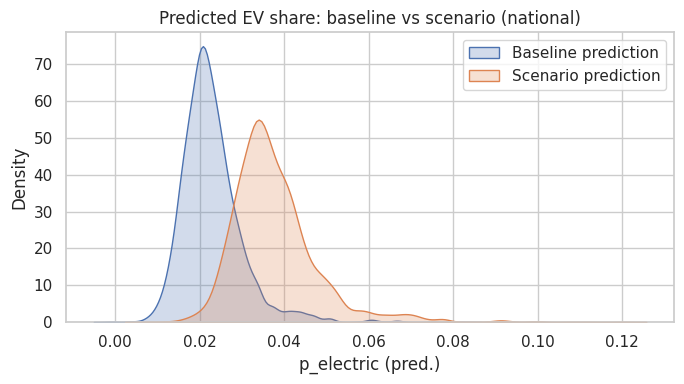

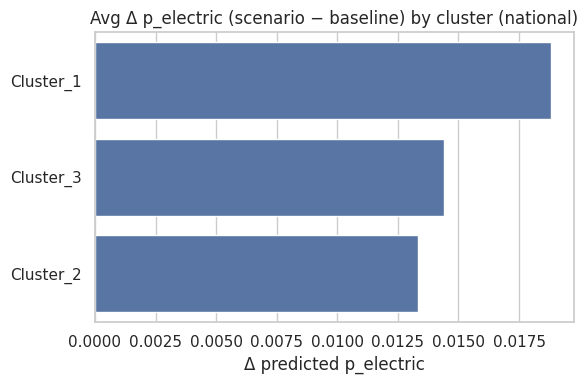

,cluster_label,delta_p_electric_hat
0,Cluster_1,0.0188
2,Cluster_3,0.0144
1,Cluster_2,0.0133


Top 10 predicted gainers (national):


,pc4,cluster_label,delta_p_electric_hat
2879,3899,Cluster_1,0.056362
756,1358,Cluster_1,0.040991
864,1488,Cluster_1,0.040563
2482,3735,Cluster_1,0.036511
865,1489,Cluster_1,0.034405
291,1077,Cluster_1,0.032936
292,1077,Cluster_1,0.032936
293,1077,Cluster_1,0.032936
294,1077,Cluster_1,0.032936
295,1077,Cluster_1,0.032936


Bottom 10 predicted gainers (national):


,pc4,cluster_label,delta_p_electric_hat
368,1101,Cluster_3,0.001580
367,1101,Cluster_3,0.001580
5578,9622,Cluster_3,0.007078
5324,9007,Cluster_3,0.007660
861,1485,Cluster_3,0.007702
4261,7605,Cluster_2,0.007743
4262,7605,Cluster_2,0.007743
4263,7605,Cluster_2,0.007743
4609,7889,Cluster_3,0.007750
3095,4104,Cluster_2,0.007758


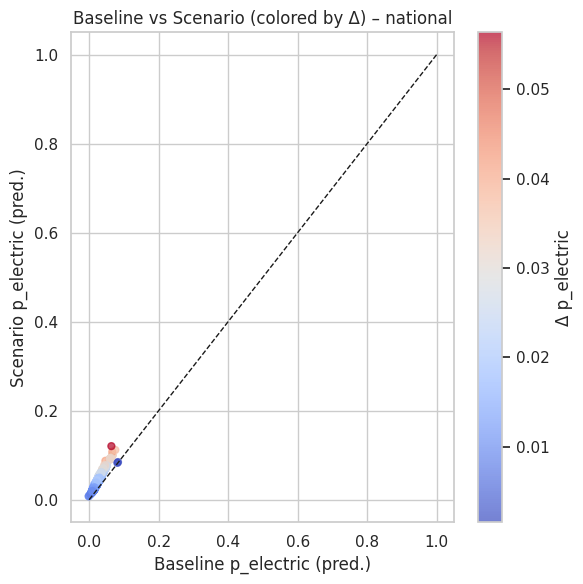

In [119]:
# Distribution: baseline vs scenario (national)
plt.figure(figsize=(7,4))
sns.kdeplot(R["p_electric_hat"], label="Baseline prediction", fill=True)
sns.kdeplot(S["p_electric_hat_scn"], label="Scenario prediction", fill=True)
plt.title("Predicted EV share: baseline vs scenario (national)")
plt.xlabel("p_electric (pred.)")
plt.legend()
plt.tight_layout()
plt.show()

# Avg uplift by cluster (national)
delta_by_cluster = (
    S.groupby("cluster_label")["delta_p_electric_hat"]
     .mean()
     .reset_index()
     .sort_values("delta_p_electric_hat", ascending=False)
)
plt.figure(figsize=(6,4))
sns.barplot(data=delta_by_cluster, y="cluster_label", x="delta_p_electric_hat", legend=False)
plt.title("Avg Δ p_electric (scenario − baseline) by cluster (national)")
plt.xlabel("Δ predicted p_electric"); plt.ylabel("")
plt.tight_layout()
plt.show()
display(delta_by_cluster)

# Top/bottom gainers (national)
top10 = S.nlargest(10, "delta_p_electric_hat")[["pc4","cluster_label","delta_p_electric_hat"]]
bottom10 = S.nsmallest(10, "delta_p_electric_hat")[["pc4","cluster_label","delta_p_electric_hat"]]
print("Top 10 predicted gainers (national):")
display(top10.style.background_gradient(subset=["delta_p_electric_hat"], cmap="Greens"))
print("Bottom 10 predicted gainers (national):")
display(bottom10.style.background_gradient(subset=["delta_p_electric_hat"], cmap="Reds"))

# Baseline vs scenario scatter (national)
plt.figure(figsize=(6,6))
plt.scatter(R["p_electric_hat"], S["p_electric_hat_scn"],
            c=S["delta_p_electric_hat"], cmap="coolwarm", s=25, alpha=0.7)
plt.plot([0,1],[0,1], 'k--', lw=1)
plt.xlabel("Baseline p_electric (pred.)")
plt.ylabel("Scenario p_electric (pred.)")
plt.title("Baseline vs Scenario (colored by Δ) – national")
cbar = plt.colorbar()
cbar.set_label("Δ p_electric")
plt.tight_layout()
plt.show()

## 15) Municipality KPIs & cluster composition + quick visuals

,municipality,pc4_count,population_total,ev_usage_mean,stations_total,ports_total,fast_ports_total,ultra_ports_total,chargers_per_10k_mean
0,Utrecht,105,"1,025,575.0000",0.0361,583.0000,"1,044.0000",8.0000,4.0000,22.5162


,cluster_label,pc4_count,mean_ev_usage,mean_income,mean_urban
1,Cluster_2,19,0.0308,28.1786,1.0893
0,Cluster_1,18,0.0435,35.2426,1.7660
2,Cluster_3,2,0.0135,32.9000,4.0000


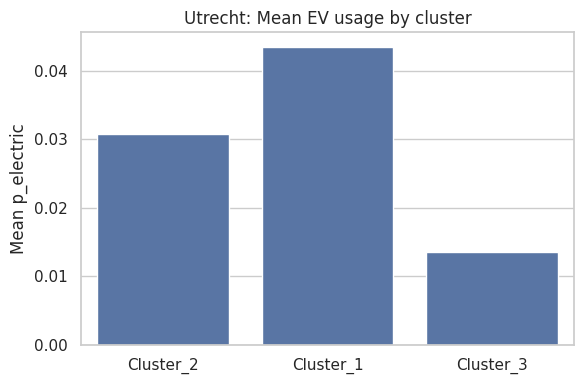

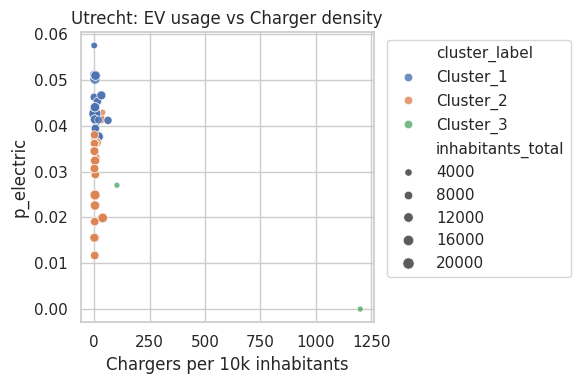

In [120]:
mun_kpis = pd.DataFrame({
    "municipality": [MUNICIPALITY],
    "pc4_count": [len(mun)],
    "population_total": [mun["inhabitants_total"].sum(skipna=True)],
    "ev_usage_mean": [mun["p_electric"].mean(skipna=True)],
    "stations_total": [mun["n_stations"].sum(skipna=True)],
    "ports_total": [mun["n_ports"].sum(skipna=True)],
    "fast_ports_total": [mun["fast_ports"].sum(skipna=True)],
    "ultra_ports_total": [mun["ultra_fast_ports"].sum(skipna=True)],
    "chargers_per_10k_mean": [mun["chargers_per_10k"].mean(skipna=True)],
})
cluster_comp = (
    mun.groupby("cluster_label", as_index=False)
       .agg(pc4_count=("pc4","nunique"),
            mean_ev_usage=("p_electric","mean"),
            mean_income=("avg_yearly_income_k","mean"),
            mean_urban=("urbanization","mean"))
       .sort_values(["pc4_count","mean_ev_usage"], ascending=[False, False])
)
display(mun_kpis)
display(cluster_comp)

# Quick plots
plt.figure(figsize=(6,4))
sns.barplot(data=cluster_comp, x="cluster_label", y="mean_ev_usage")
plt.title(f"{MUNICIPALITY}: Mean EV usage by cluster")
plt.xlabel(""); plt.ylabel("Mean p_electric")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=mun, x="chargers_per_10k", y="p_electric",
    size="inhabitants_total", hue="cluster_label", alpha=0.8
)
plt.title(f"{MUNICIPALITY}: EV usage vs Charger density")
plt.xlabel("Chargers per 10k inhabitants"); plt.ylabel("p_electric")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## 16) 'Driver card' – explain WHY a PC4 looks high/low (vs municipality or cluster)

Top ± deviations on key drivers with arrows, standardized within the municipality for comparability.


In [121]:
# Precompute municipality medians/means/std
driver_cols = ["avg_yearly_income_k","urbanization","p_hybrid","p_gasoline","p_diesel",
               "chargers_per_10k","stations_per_10k"]
driver_labels = {
    "avg_yearly_income_k": "Income",
    "urbanization": "Urbanization",
    "p_hybrid": "Hybrid share",
    "p_gasoline": "Gasoline share",
    "p_diesel": "Diesel share",
    "chargers_per_10k": "Chargers / 10k",
    "stations_per_10k": "Stations / 10k",
}

mun_median = mun[driver_cols].median(numeric_only=True)
cluster_ref = (
    mun.groupby("cluster_label", as_index=False)[driver_cols]
       .median(numeric_only=True)
       .set_index("cluster_label")
)
mun_mean = mun[driver_cols].mean(numeric_only=True)
mun_std  = mun[driver_cols].std(ddof=0, numeric_only=True).replace(0, 1e-9)

# Which drivers are "good" when higher (for EV adoption expectation)
positive_good = {"avg_yearly_income_k", "urbanization", "p_hybrid", "chargers_per_10k", "stations_per_10k"}

def driver_card(pc4: int, ref="municipality", top_k=4) -> str:
    """
    Build a short textual explanation for a given PC4.
    ref: 'municipality' or 'cluster'
    """
    row = mun.loc[mun["pc4"] == pc4]
    if row.empty:
        return f"PC4 {pc4}: not found in municipality selection."

    row = row.iloc[0]
    vals = row[driver_cols]

    if ref == "cluster" and row["cluster_label"] in cluster_ref.index:
        baseline = cluster_ref.loc[row["cluster_label"], driver_cols]
        ref_name = f"cluster {row['cluster_label']}"
    else:
        baseline = mun_median
        ref_name = "municipality median"

    # z-scale by municipality spread for comparability
    z = (vals - mun_mean) / mun_std

    # Rank by |z| and compose arrows
    impact = []
    for c in driver_cols:
        name = driver_labels[c]
        z_val = z[c]
        sign_good = (c in positive_good)
        arrow = "↑" if ((z_val > 0) == sign_good) else "↓"
        impact.append((c, name, z_val, arrow))
    impact_sorted = sorted(impact, key=lambda t: abs(t[2]), reverse=True)

    parts = [f"{arrow} {name}" for (_, name, _, arrow) in impact_sorted[:top_k]]
    return (f"PC4 {pc4}: vs {ref_name} — " +
            ", ".join(parts) +
            f". (EV now: {row['p_electric']:.3f}, chargers/10k: {row['chargers_per_10k']:.2f}, conf: {row['cluster_confidence']:.2f})")

# EXAMPLES:
print(driver_card(3543, ref="municipality"))
print(driver_card(3543, ref="cluster"))

PC4 3543: vs municipality median — ↑ Hybrid share, ↑ Gasoline share, ↑ Income, ↑ Urbanization. (EV now: 0.051, chargers/10k: 6.00, conf: 0.84)
PC4 3543: vs cluster Cluster_1 — ↑ Hybrid share, ↑ Gasoline share, ↑ Income, ↑ Urbanization. (EV now: 0.051, chargers/10k: 6.00, conf: 0.84)


## 17) (Optional) Temporal forecasting per PC4 (monthly)

If you provide a monthly RDW PC4 time-series at `RDW_MONTHLY_PATH` with columns:
- pc4 (int), date (YYYY-MM), p_electric (float in [0,1])
We will:
- sort by date, ensure monthly freq, fill small gaps with 0,
- choose ETS/Holt-Winters model robustly:
   * if ≥ 24 points & ≥ 2 seasonal cycles (m=12) → seasonal additive,
   * else → non-seasonal ETS,
- produce h-step forecast with 95% PI and compute hold-out SMAPE if enough history.

If file not present or schema missing, this section safely skips.

In [123]:
import os

RDW_MONTHLY_PATH=''
def try_read_rdw_monthly(path: str):
    if not os.path.exists(path):
        return None
    try:
        df = pd.read_csv(path)
        needed = {"pc4","date","p_electric"}
        if not needed.issubset(set(df.columns)):
            print("[Temporal] Missing required columns in RDW file; skipping.")
            return None
        df["pc4"] = pd.to_numeric(df["pc4"], errors="coerce").astype("Int64")
        df = df.dropna(subset=["pc4","date","p_electric"]).copy()
        df["pc4"] = df["pc4"].astype(int)
        df["date"] = pd.to_datetime(df["date"])
        df = df.sort_values(["pc4","date"])
        return df
    except Exception as e:
        print("[Temporal] Failed to read RDW file:", e)
        return None

rdw = try_read_rdw_monthly(RDW_MONTHLY_PATH)

if rdw is not None and not rdw.empty:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    print("[Temporal] RDW monthly loaded. Example head:")
    display(rdw.head())

    def forecast_pc4_group(g: pd.DataFrame, horizon=12, m=12):
        # ensure monthly freq
        ts = g.set_index("date")["p_electric"].asfreq("MS")
        ts = ts.fillna(0.0)
        n = len(ts)

        # holdout for SMAPE (20% capped at 12)
        h = min(horizon, max(1, n // 5))
        train = ts.iloc[:-h] if n > h else ts
        test  = ts.iloc[-h:] if n > h else None

        seasonal_ok = (len(train) >= 2*m)  # ≥ two full cycles
        try:
            if seasonal_ok:
                model = ExponentialSmoothing(
                    train, trend="add", seasonal="add", seasonal_periods=m, initialization_method="estimated"
                ).fit(optimized=True)
            else:
                model = ExponentialSmoothing(
                    train, trend="add", seasonal=None, initialization_method="estimated"
                ).fit(optimized=True)
        except Exception:
            # conservative fallback
            model = ExponentialSmoothing(
                train, trend=None, seasonal=None, initialization_method="estimated"
            ).fit(optimized=True)

        fc = model.forecast(horizon)
        # crude 95% PI via residual std
        resid = train - model.fittedvalues.reindex(train.index).fillna(method="bfill").fillna(method="ffill")
        sigma = float(np.nanstd(resid))
        pi_low  = fc - 1.96 * sigma
        pi_high = fc + 1.96 * sigma

        score = None
        if test is not None and len(test) > 0:
            bt = model.forecast(len(test))
            score = smape_numpy(test.values, bt.values)

        df_fc = pd.DataFrame({
            "date": pd.date_range(start=ts.index.max() + pd.offsets.MonthBegin(1), periods=horizon, freq="MS"),
            "p_electric_fc": fc.values,
            "pi_low": pi_low.values,
            "pi_high": pi_high.values
        })
        return df_fc, score

    # Demo on municipality PC4s (first 5 to keep it light)
    pc4_list = list(sorted(set(mun["pc4"])))[:5]
    all_fc = []
    scores = []
    for p in pc4_list:
        g = rdw[rdw["pc4"] == p]
        if g.empty:
            continue
        fc, s = forecast_pc4_group(g, horizon=12, m=12)
        fc.insert(0, "pc4", p)
        all_fc.append(fc)
        scores.append((p, s))
    if all_fc:
        fc_df = pd.concat(all_fc, ignore_index=True)
        print("[Temporal] Example forecasts (first PC4s):")
        display(fc_df.head(12))
    if scores:
        print("[Temporal] Hold-out SMAPE by PC4 (if computed):")
        display(pd.DataFrame(scores, columns=["pc4","SMAPE"]).dropna())
else:
    print("[Temporal] RDW monthly file not provided; skipping temporal forecasting section.")

[Temporal] RDW monthly file not provided; skipping temporal forecasting section.


## 17) CSV exports for dashboard integration

In [ ]:
# Merge scenario deltas back for convenience
joined = R.merge(
    S[["pc4", "p_electric_hat_scn", "delta_p_electric_hat"]],
    on="pc4", how="left"
)

R[["pc4","cluster_label","p_electric","p_hybrid","p_gasoline","p_diesel",
   "avg_yearly_income_k","urbanization","avg_household_size",
   "inhabitants_total","EV_Potential_0_100","Opportunity"]].to_csv(
    "regions_ev_clusters.csv", index=False)

R[["pc4","EV_Potential_0_100","EV_Potential_raw","Opportunity"]].to_csv(
    "regions_ev_opportunity.csv", index=False)

joined[["pc4","p_electric","p_electric_hat","p_electric_hat_scn","delta_p_electric_hat"]].to_csv(
    "regions_ev_whatif.csv", index=False)

forecast_view.to_csv(f"forecast_{MUNICIPALITY.lower()}.csv", index=False)

print("[ok] CSVs exported.")
